In [2]:
# !pip install pykan

In [1]:
import torch
import matplotlib.pyplot as plt
from kan import KAN, create_dataset
from kan.MLP import MLP as kan_MLP
from kan.feynman import get_feynman_dataset

In [2]:
torch.cuda.is_available()

False

In [3]:
class MLP(kan_MLP):

    def __init__(self, width, act='silu', save_act=True, seed=0, device='cpu'):
        super(MLP, self).__init__(width, act, save_act, seed, device)
    
        if act == 'silu':
            self.act_fun = torch.nn.SiLU()
        elif act == 'relu':
            self.act_fun = torch.nn.ReLU()
        elif act == 'tanh':
            self.act_fun = torch.nn.Tanh()

In [12]:
model = KAN(width=[2,5,1])
symbol, expr, f, ranges = get_feynman_dataset('I.6.20')
dataset = create_dataset(f)

checkpoint directory created: ./model
saving model version 0.0


In [15]:
model.evaluate(dataset)

{'test_loss': 1.646736741065979, 'n_edge': 15, 'n_grid': 3}

## Experiment Functions

In [33]:
def run_kan_feynman(dataset: str,
                          shape: list[int],
                          samples: int, # samples for both train and test (separated) sets
                          start_grid: int = 3,
                          k: int = 3,
                          device='cuda' if torch.cuda.is_available() else 'cpu',
                          seed:int=42,
                          grids=[3, 5, 10, 20, 50, 100, 200],
                          steps_per_grid=200,
                          plot_model=False,
                          prune=False,
                          prune_threshold=1e-2,
                          steps_after_prune=50,
                          lamb=0.00,
                          opt="LBFGS",
                          **kwargs):
    
    assert device in ['cpu', 'cuda']
    try:
        torch.manual_seed(seed)
    except Exception as e:
        print('Warning: could not set torch.manual_seed')
    
    try:
        symbol, expr, f, ranges = get_feynman_dataset(dataset)
    except ValueError:
        raise ValueError("Invalid dataset name")

    dataset = create_dataset(f, n_var=len(ranges), ranges=ranges, train_num=samples, test_num=samples, seed=seed)

    dataset['train_input'] = dataset['train_input'].to(device)
    dataset['train_label'] = dataset['train_label'].to(device)
    dataset['test_input'] = dataset['test_input'].to(device)
    dataset['test_label'] = dataset['test_label'].to(device)

    # assert shape[0] == len(ranges), "Input dimension does not match number of variables in dataset"
    # print(shape)
    if not shape[-1] == 1:
        print(f"Warning: Output dimension {shape[-1]} is not 1. Forcing condition.")
        shape[-1] = 1
    if not shape[0] == len(ranges):
        print(f"Warning: Input dimension {shape[0]} does not match number of variables in dataset {len(ranges)}. Forcing condition.")
        shape[0] = len(ranges)

    # Create a copy of shape before passing to KAN to avoid mutation
    # KAN's __init__ converts [2,5,1] to [[2,0],[5,0],[1,0]] in-place
    model = KAN(width=shape.copy(), grid=start_grid, k=k, seed=seed).to(device)

    per_grid_results = {}

    for i, g in enumerate(grids):
        if i > 0: #skip first iteration
            model = model.refine(g)
        
        print(f"Training grid: {g}")
        results = model.fit(dataset, opt=opt, steps=steps_per_grid, lamb=lamb)
        per_grid_results[g] = results

    if prune:
        print("Pruning model...")
        model = model.prune(prune_threshold)
        # Disable grid updates after pruning to avoid numerical instability with smaller network
        results = model.fit(dataset, opt=opt, steps=steps_after_prune, lamb=0.0, update_grid=False)
        per_grid_results['prunning'] = results

    if plot_model:
        model.plot()
        plt.show()

    best_test_rmse = min(per_grid_results.values(), key=lambda x: x['test_loss'][-1])['test_loss'][-1]
    
    return model, per_grid_results, best_test_rmse

In [34]:
def sweep_kan_feynman(dataset:str, width: int=5, depths=[2,3,4,5,6], seeds: list[int] = [42, 171, 3], lambs: list[float] = [0.0], **kwargs):

    all_results = {}
    best_test_rmse = float('inf')
    
    # Get dataset info to determine input dimension
    try:
        symbol, expr, f, ranges = get_feynman_dataset(dataset)
        n_inputs = len(ranges)
    except Exception as e:
        raise ValueError(f"Could not load dataset {dataset}")

    for depth in depths:
        all_results[depth] = {}
        for lamb in lambs:
            all_results[depth][lamb] = {}
            for seed in seeds:
                all_results[depth][lamb][seed] = {}
                # Build shape with correct input dimension and output dimension of 1
                # depth includes input and output layers, so we need depth-2 hidden layers
                if depth == 1:
                    shape = [n_inputs, 1]
                else:
                    shape = [n_inputs] + [width for _ in range(depth - 1)] + [1]


                try:
                    model, per_grid_results, test_rmse = run_kan_feynman(dataset=dataset, shape=shape, lamb=lamb, seed=seed, **kwargs)
                        
                except Exception as e:
                    print(f"Error running run_kan_feynman with depth={depth}, lamb={lamb}, seed={seed}: {e}")
                    model, per_grid_results, test_rmse = None, None, float('inf')
                    
                all_results[depth][lamb][seed] = {
                    'model': model,
                    'per_grid_results': per_grid_results,
                    'test_rmse': test_rmse
                }

                if test_rmse < best_test_rmse:
                    best_test_rmse = test_rmse

    return all_results, best_test_rmse

In [35]:
def feynman_human_kan_experiment(dataset: str, shape: list[int], seeds: int| list[int] = [42, 171, 3], samples: int = 1000, **kwargs):
    """
    Run feynman dataset experiment with human-constructed KAN
    """
    all_results = []
    for seed in seeds:
        results = run_kan_feynman(dataset=dataset,
                                seed=seed,
                                samples=samples,
                                shape=shape,
                                **kwargs)
        all_results.append(results)
    
    best_test_rmse = min([res[2] for res in all_results])

    print('==='*20)
    print(f'Best Test RMSE for human-constructed KAN on dataset {dataset}: {best_test_rmse:.4e}')

    return best_test_rmse, all_results
    

def feynman_not_pruned_kan_experiment(dataset: str, seeds: int | list[int], samples=1000, **kwargs):

    results = sweep_kan_feynman(dataset=dataset,
                                seeds=seeds,
                                samples=samples,
                                **kwargs)

    # print('==='*20)
    # print(f'Best Test RMSE for not pruned KAN on dataset {dataset}: {results[1]:.4e}')
    best_test_rmse = results[1]

    return best_test_rmse, results


def feynman_pruned_kan_experiment(dataset: str, seeds: int|list[int] = [42, 171, 3], samples: int = 1000, steps_after_prune: int = 100,  lambs=[1e-2, 1e-3], **kwargs):
    """
    Run feynman dataset experiment with pruned KAN
    """
    results, best_test_rmse = sweep_kan_feynman(dataset=dataset,
                                seeds=seeds,
                                samples=samples,
                                prune=True,
                                prune_threshold=0.01,
                                steps_after_prune=steps_after_prune,
                                lambs=lambs,
                                **kwargs)
    

    # get smallest shape with loss < 1e-2
    # get shape of best loss

    smallest_shape = None
    smallest_params = float('inf')
    shape_best_loss = None
    smallest_loss = float('inf')

    for depth, v in results.items():
        for lamb, vv in v.items():
            for seed, res in vv.items():
                test_rmse = res['test_rmse']
                model = res['model']
                shape = [p[0] if isinstance(p, list) else p for p in model.width]
                num_params = sum(p.numel() for p in model.parameters())


                if test_rmse < 1e-2:
                    if smallest_shape is None or sum(shape) < sum(smallest_shape):
                        if num_params > smallest_params and smallest_shape is not None:
                            print(f"Warning: Found smaller shape {shape} with more parameters {num_params} > {smallest_params}. Still taking smallest shape though.")
                        smallest_shape = shape
                        smallest_params = num_params

                if test_rmse < smallest_loss:
                    smallest_loss = test_rmse
                    shape_best_loss = shape


    
    # If no model achieved RMSE < 1e-2, print warning
    if smallest_shape is None:

        print(f"⚠️ WARNING: No model achieved RMSE < 1e-2 for dataset {dataset}")


    return smallest_shape, shape_best_loss, best_test_rmse, results

In [36]:
def feynman_mlp_experiment(dataset: str, seeds: int|list[int] = [42, 171, 3], samples: int = 1000, device='cuda' if torch.cuda.is_available() else 'cpu',
                           activations=['silu', 'relu', 'tanh'], depths = [2,3,4,5,6], steps=1400, lr=1, **kwargs):
    """
    Run feynman dataset experiment with MLP
    """

    assert device in ['cpu', 'cuda']

    all_results = {}
    best_test_rmse = float('inf')

    try:
        symbol, expr, f, ranges = get_feynman_dataset(dataset)
    except ValueError:
        raise ValueError("Invalid dataset name")
    
    for seed in seeds:
        try:
            torch.manual_seed(seed)
        except Exception as e:
            print(f"Warning: could not set seed due to error: {e}")

        dataset = create_dataset(f, n_var=len(ranges), ranges=ranges, train_num=samples, test_num=samples, seed=seed)
        dataset['train_input'] = dataset['train_input'].to(device)
        dataset['train_label'] = dataset['train_label'].to(device)
        dataset['test_input'] = dataset['test_input'].to(device)
        dataset['test_label'] = dataset['test_label'].to(device)

        all_results[seed] = {}
        
        for depth in depths:
            shape = [len(ranges)] + [5 for _ in range(depth-1)] + [1]

            all_results[seed][depth] = {}

            for act in activations:
                model = MLP(width=shape, act=act, seed=seed, device=device)

                results = model.fit(dataset=dataset, steps=steps, opt="LBFGS", lr=lr)
                all_results[seed][depth][act] = results

                test_rmse = min(results['test_loss'])

                if test_rmse < best_test_rmse:
                    best_test_rmse = test_rmse
                
    return all_results, best_test_rmse

In [37]:
def full_feynman_experiment(dataset: str, shape_human: list[int], seeds: list[int] = [42, 171, 3], samples: int = 1000, skip = [], **kwargs):
    """
    Run full feynman dataset experiment with human-constructed KAN, not pruned KAN, pruned KAN, and MLP
    """

    pruned_smallest_shape, pruned_shape_best_loss, pruned_best_rmse = None, None, None
    h_best_test_rmse, not_pruned_best_rmse, mlp_best_rmse = None, None, None

    if 'human' not in skip:
        print('Running Human-constructed KAN Experiment...')
        h_best_test_rmse, h_results = feynman_human_kan_experiment(dataset=dataset, shape=shape_human, seeds=seeds, samples=samples, **kwargs)
        print(f'Best Test RMSE for human-constructed KAN on dataset {dataset}: {h_best_test_rmse:.4e}')

    if 'unpruned' not in skip:
        print('--------------------------------') 
        print('Running Not Pruned KAN Experiment...')
        not_pruned_best_rmse, not_pruned_results = feynman_not_pruned_kan_experiment(dataset=dataset, seeds=seeds, samples=samples, **kwargs)
        print(f'Best Test RMSE for not pruned KAN on dataset {dataset}: {not_pruned_best_rmse:.4e}')

    if 'pruned' not in skip:
        print('--------------------------------') 
        print('Running Pruned KAN Experiment...')
        pruned_smallest_shape, pruned_shape_best_loss, pruned_best_rmse, pruned_results = feynman_pruned_kan_experiment(dataset=dataset, seeds=seeds, samples=samples, **kwargs)
        print(f'Pruned KAN Smallest Shape: {pruned_smallest_shape}, ')
        print(f'Pruned KAN lowest loss Shape: {pruned_shape_best_loss}, ')
        print(f'Pruned KAN lowest loss: {pruned_best_rmse:.4e}')

    if 'mlp' not in skip:
        print('--------------------------------') 
        print('Running MLP Experiment...')
        mlp_results, mlp_best_rmse = feynman_mlp_experiment(dataset=dataset, seeds=seeds, samples=samples, **kwargs)
        print(f'MLP lowest loss: {mlp_best_rmse:.4e}')

    print('--------------------------------') 
    print('==='*40)
    print('==='*40)
    print(f'Final Results for dataset {dataset}:')

    if 'pruned' not in skip:
        print(f'Pruned KAN Smallest Shape: {pruned_smallest_shape}, ')
        print(f'Pruned KAN lowest loss Shape: {pruned_shape_best_loss}, ')
        print(f'Pruned KAN lowest loss: {pruned_best_rmse:.4e}')
    if 'human' not in skip:
        print(f'Human-constructed KAN loss: {h_best_test_rmse:.4e}')
    if 'unpruned' not in skip:
        print(f'UnPruned KAN lowest loss: {not_pruned_best_rmse:.4e}')
    if 'mlp' not in skip:
        print(f'MLP lowest loss: {mlp_best_rmse:.4e}')
    print('==='*40)
    print('==='*40)

    # save results
    full_results = {
        'human': {
            'best_rmse': h_best_test_rmse,
            'results': h_results
        } if 'human' not in skip else None,
        'not_pruned': {
            'best_rmse': not_pruned_best_rmse,
            'results': not_pruned_results
        } if 'unpruned' not in skip else None,
        'pruned': {
            'smallest_shape': pruned_smallest_shape,
            'shape_best_loss': pruned_shape_best_loss,
            'best_rmse': pruned_best_rmse,
            'results': pruned_results
        } if 'pruned' not in skip else None,
        'mlp': {
            'best_rmse': mlp_best_rmse,
            'results': mlp_results
        } if 'mlp' not in skip else None    
    }

    return full_results

## Experiments

--------------------------------
Running Pruned KAN Experiment...


checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 1.29e-01 | test_loss: 1.33e-01 | reg: 1.22e+01 | : 100%|█| 200/200 [00:52<00:00,  3.82


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 1.21e-01 | test_loss: 1.48e-01 | reg: 1.21e+01 | : 100%|█| 200/200 [00:39<00:00,  5.05


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 1.15e-01 | test_loss: 1.47e-01 | reg: 1.21e+01 | : 100%|█| 200/200 [00:48<00:00,  4.16


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 1.02e-01 | test_loss: 1.60e-01 | reg: 1.20e+01 | : 100%|█| 200/200 [01:11<00:00,  2.81


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 1.01e-01 | test_loss: 1.60e-01 | reg: 1.20e+01 | : 100%|█| 200/200 [00:49<00:00,  4.03


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 1.02e-01 | test_loss: 1.72e-01 | reg: 1.20e+01 | : 100%|█| 200/200 [00:48<00:00,  4.15


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 4.08e-02 | test_loss: 2.48e-01 | reg: 1.12e+01 | : 100%|█| 200/200 [01:53<00:00,  1.76


saving model version 0.13


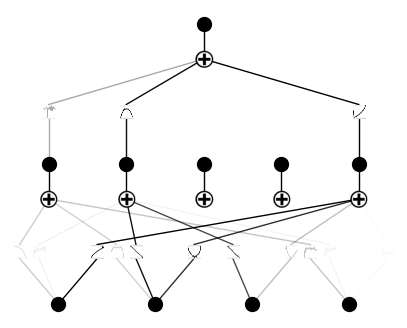

Pruning model...
saving model version 0.14


| train_loss: 5.64e-03 | test_loss: 2.40e-01 | reg: 1.28e+01 | : 100%|█| 100/100 [00:39<00:00,  2.51


saving model version 0.15


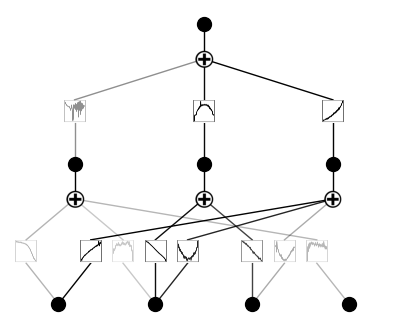

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 5.16e-02 | test_loss: 8.61e-02 | reg: 1.87e+01 | : 100%|█| 200/200 [01:07<00:00,  2.95


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 3.67e-02 | test_loss: 7.33e-02 | reg: 1.69e+01 | : 100%|█| 200/200 [01:12<00:00,  2.74


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 3.09e-02 | test_loss: 7.49e-02 | reg: 1.57e+01 | : 100%|█| 200/200 [01:10<00:00,  2.84


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 2.59e-02 | test_loss: 8.50e-02 | reg: 1.49e+01 | : 100%|█| 200/200 [00:49<00:00,  4.04


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 1.32e-02 | test_loss: 4.17e-01 | reg: 1.56e+01 | : 100%|█| 200/200 [01:00<00:00,  3.30


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 5.70e-03 | test_loss: 5.47e-01 | reg: 1.65e+01 | : 100%|█| 200/200 [01:12<00:00,  2.75


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 5.01e-03 | test_loss: 6.17e-01 | reg: 1.57e+01 | : 100%|█| 200/200 [01:33<00:00,  2.13


saving model version 0.13


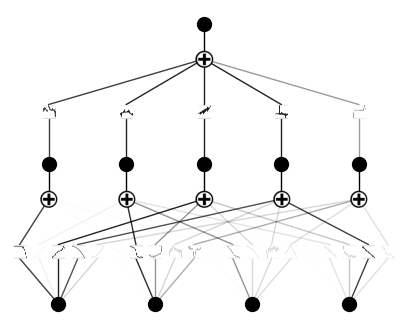

Pruning model...
saving model version 0.14


| train_loss: 8.19e-05 | test_loss: 6.54e-01 | reg: 1.63e+01 | : 100%|█| 100/100 [00:37<00:00,  2.69


saving model version 0.15


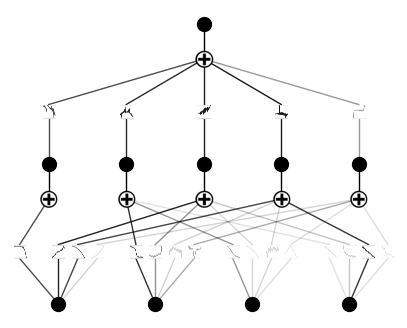

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 7.47e-02 | test_loss: 1.26e-01 | reg: 9.44e+00 | : 100%|█| 200/200 [01:27<00:00,  2.30


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 8.93e-01 | test_loss: 7.76e-01 | reg: 2.01e-01 | : 100%|█| 200/200 [01:10<00:00,  2.84


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 8.93e-01 | test_loss: 7.76e-01 | reg: 1.97e-01 | : 100%|█| 200/200 [00:58<00:00,  3.40


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 8.93e-01 | test_loss: 7.76e-01 | reg: 1.86e-01 | : 100%|█| 200/200 [00:34<00:00,  5.81


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 8.93e-01 | test_loss: 7.76e-01 | reg: 1.75e-01 | : 100%|█| 200/200 [00:50<00:00,  3.98


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 8.93e-01 | test_loss: 7.76e-01 | reg: 2.06e-01 | : 100%|█| 200/200 [00:51<00:00,  3.88


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 8.93e-01 | test_loss: 7.76e-01 | reg: 2.62e-01 | : 100%|█| 200/200 [2:14:52<00:00, 40.


saving model version 0.13


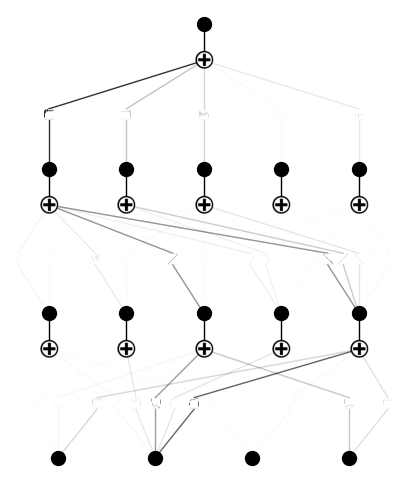

Pruning model...
saving model version 0.14


| train_loss: 5.52e-01 | test_loss: 4.50e-01 | reg: 0.00e+00 | :  44%|▍| 44/100 [56:01<1:11:18, 76.4


KeyboardInterrupt: 

In [9]:
results_I_6_20 = full_feynman_experiment(dataset='I.15.3x', shape_human=[6, 4, 2, 1, 1], seeds=[1], skip=['unpruned','human','mlp'], depths=[2,3,4], plot_model=True, plot_before_prune=True)

In [10]:
results_I_6_20b = full_feynman_experiment(dataset='I.16.6', shape_human=[3,2,2,1,1], seeds=[3], skip=['unpruned','human','mlp'], depths=[2,3], plot_model=True, plot_before_prune=True)

--------------------------------
Running Pruned KAN Experiment...
checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


description:   0%|                                                          | 0/200 [00:00<?, ?it/s]

| train_loss: 2.33e-01 | test_loss: 2.27e-01 | reg: 2.51e-01 | : 100%|█| 200/200 [01:34<00:00,  2.12


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 2.33e-01 | test_loss: 2.27e-01 | reg: 1.10e-01 | : 100%|█| 200/200 [01:27<00:00,  2.27


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 2.33e-01 | test_loss: 2.27e-01 | reg: 3.21e-02 | : 100%|█| 200/200 [00:35<00:00,  5.71


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 2.33e-01 | test_loss: 2.27e-01 | reg: 9.71e-03 | : 100%|█| 200/200 [00:31<00:00,  6.37


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 2.34e-01 | test_loss: 2.28e-01 | reg: 2.77e-03 | : 100%|█| 200/200 [00:59<00:00,  3.38


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 2.33e-01 | test_loss: 2.27e-01 | reg: 3.49e-03 | : 100%|█| 200/200 [01:09<00:00,  2.88


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: nan | test_loss: nan | reg: nan | :   2%|▎            | 5/200 [00:02<01:40,  1.93it/s]


Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGE

| train_loss: nan | test_loss: nan | reg: nan | :   2%|▎            | 5/200 [00:03<02:08,  1.51it/s]

lstsq failed
Error running run_kan_feynman with depth=2, lamb=0.01, seed=3: cannot access local variable 'coef' where it is not associated with a value


checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 2.63e-02 | test_loss: 2.87e-02 | reg: 5.84e+00 | : 100%|█| 200/200 [00:59<00:00,  3.34


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 2.30e-02 | test_loss: 2.65e-02 | reg: 5.74e+00 | : 100%|█| 200/200 [01:06<00:00,  3.00


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 2.20e-02 | test_loss: 2.68e-02 | reg: 5.66e+00 | : 100%|█| 200/200 [00:54<00:00,  3.66


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 2.05e-02 | test_loss: 2.76e-02 | reg: 5.67e+00 | : 100%|█| 200/200 [00:36<00:00,  5.43


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 1.77e-02 | test_loss: 2.81e-02 | reg: 5.67e+00 | : 100%|█| 200/200 [00:57<00:00,  3.49


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 1.77e-02 | test_loss: 2.81e-02 | reg: 5.67e+00 | : 100%|█| 200/200 [01:06<00:00,  3.02


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: nan | test_loss: nan | reg: nan | :   2%|▎            | 5/200 [00:02<01:42,  1.91it/s]



Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGE

| train_loss: 2.33e-01 | test_loss: 2.27e-01 | reg: 2.92e-01 | : 100%|█| 200/200 [00:48<00:00,  4.09


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 2.33e-01 | test_loss: 2.27e-01 | reg: 2.48e-01 | : 100%|█| 200/200 [00:47<00:00,  4.22


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 2.33e-01 | test_loss: 2.27e-01 | reg: 3.92e-01 | : 100%|█| 200/200 [00:35<00:00,  5.66


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 2.35e-01 | test_loss: 2.28e-01 | reg: 7.45e-02 | : 100%|█| 200/200 [01:03<00:00,  3.14


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 2.36e-01 | test_loss: 2.29e-01 | reg: 6.47e-02 | : 100%|█| 200/200 [00:46<00:00,  4.29


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 2.34e-01 | test_loss: 2.28e-01 | reg: 6.82e-02 | : 100%|█| 200/200 [00:39<00:00,  5.06


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 2.35e-01 | test_loss: 2.28e-01 | reg: 1.34e-01 | :  57%|▌| 115/200 [1:14:27<55:01, 38.


KeyboardInterrupt: 

--------------------------------
Running Pruned KAN Experiment...
checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


description:   0%|                                                          | 0/200 [00:00<?, ?it/s]

| train_loss: 2.33e-01 | test_loss: 2.27e-01 | reg: 4.33e-02 | : 100%|█| 200/200 [00:40<00:00,  4.98


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 2.33e-01 | test_loss: 2.27e-01 | reg: 2.40e-02 | : 100%|█| 200/200 [00:38<00:00,  5.19


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 2.33e-01 | test_loss: 2.27e-01 | reg: 1.54e-02 | : 100%|█| 200/200 [00:30<00:00,  6.59


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: nan | test_loss: nan | reg: nan | :   8%|▉           | 15/200 [00:03<00:43,  4.26it/s]



Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGE

| train_loss: 2.61e-02 | test_loss: 2.86e-02 | reg: 5.83e+00 | : 100%|█| 200/200 [00:40<00:00,  4.92


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 2.28e-02 | test_loss: 2.69e-02 | reg: 5.66e+00 | : 100%|█| 200/200 [00:46<00:00,  4.31


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 2.25e-02 | test_loss: 2.72e-02 | reg: 5.67e+00 | : 100%|█| 200/200 [00:31<00:00,  6.26


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 2.08e-02 | test_loss: 2.73e-02 | reg: 5.63e+00 | : 100%|█| 200/200 [00:59<00:00,  3.36


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 2.03e-02 | test_loss: 2.73e-02 | reg: 5.63e+00 | : 100%|█| 200/200 [00:29<00:00,  6.88


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 2.03e-02 | test_loss: 2.73e-02 | reg: 5.63e+00 | : 100%|█| 200/200 [00:18<00:00, 10.86


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 1.16e-02 | test_loss: 2.91e-02 | reg: 5.65e+00 | : 100%|█| 200/200 [01:28<00:00,  2.25


saving model version 0.13
Pruning model...
saving model version 0.14


| train_loss: 6.42e-02 | test_loss: 1.88e-01 | reg: 9.15e+00 | : 100%|█| 100/100 [00:30<00:00,  3.25


saving model version 0.15


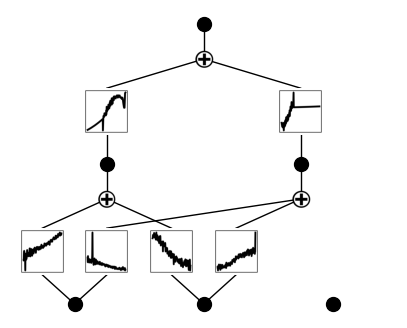

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 2.33e-01 | test_loss: 2.27e-01 | reg: 2.79e-01 | : 100%|█| 200/200 [00:35<00:00,  5.67


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 2.33e-01 | test_loss: 2.27e-01 | reg: 1.44e-01 | : 100%|█| 200/200 [01:11<00:00,  2.79


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 2.36e-01 | test_loss: 2.29e-01 | reg: 7.18e-02 | : 100%|█| 200/200 [00:56<00:00,  3.53


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 2.36e-01 | test_loss: 2.29e-01 | reg: 3.34e-02 | : 100%|█| 200/200 [00:50<00:00,  3.97


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 2.36e-01 | test_loss: 2.29e-01 | reg: 7.44e-02 | : 100%|█| 200/200 [00:50<00:00,  3.96


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 2.35e-01 | test_loss: 2.28e-01 | reg: 4.29e-02 | : 100%|█| 200/200 [00:49<00:00,  4.01


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 2.34e-01 | test_loss: 2.28e-01 | reg: 7.57e-02 | : 100%|█| 200/200 [01:08<00:00,  2.94


saving model version 0.13
Pruning model...
saving model version 0.14


| train_loss: 2.34e-01 | test_loss: 2.27e-01 | reg: 5.63e-02 | : 100%|█| 100/100 [00:03<00:00, 28.99


saving model version 0.15


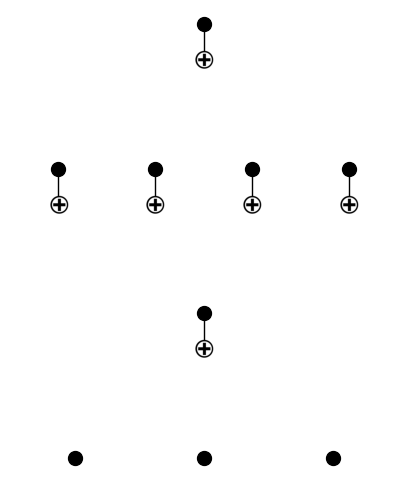

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 1.18e-02 | test_loss: 1.62e-02 | reg: 3.79e+00 | : 100%|█| 200/200 [01:31<00:00,  2.19


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 9.16e-03 | test_loss: 1.10e-02 | reg: 3.59e+00 | : 100%|█| 200/200 [01:29<00:00,  2.23


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 6.32e-02 | test_loss: 1.60e-01 | reg: 8.09e+00 | : 100%|█| 200/200 [01:39<00:00,  2.00


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 4.46e-02 | test_loss: 1.75e-01 | reg: 7.99e+00 | : 100%|█| 200/200 [01:42<00:00,  1.94


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 3.83e-02 | test_loss: 2.26e-01 | reg: 7.96e+00 | : 100%|█| 200/200 [01:57<00:00,  1.71


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 3.77e-02 | test_loss: 1.75e-01 | reg: 7.86e+00 | : 100%|█| 200/200 [02:20<00:00,  1.43


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 3.98e-02 | test_loss: 1.81e-01 | reg: 7.55e+00 | : 100%|█| 200/200 [03:24<00:00,  1.02


saving model version 0.13
Pruning model...
saving model version 0.14


| train_loss: 1.34e-01 | test_loss: 2.23e-01 | reg: 6.39e+00 | : 100%|█| 100/100 [01:23<00:00,  1.20


saving model version 0.15


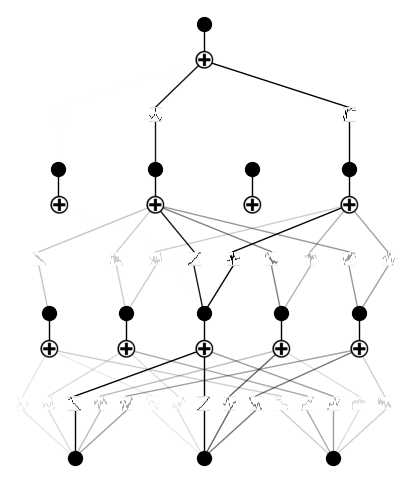

AttributeError: 'NoneType' object has no attribute 'width'

In [38]:
results_I_6_20b = full_feynman_experiment(dataset='I.16.6', shape_human=[3,2,2,1,1], seeds=[3], skip=['unpruned','human','mlp'], depths=[2,3], plot_model=True, plot_before_prune=True)

In [10]:
results_III_17_37 = full_feynman_experiment(dataset='III.17.37', shape_human=[3,3,3,2,2,1], seeds=[171], skip=['pruned'])

Running Human-constructed KAN Experiment...


checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 4.23e-03 | test_loss: 5.76e-03 | reg: 2.32e+01 | : 100%|█| 200/200 [01:42<00:00,  1.96


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 2.95e-02 | test_loss: 6.72e-02 | reg: 2.55e+01 | : 100%|█| 200/200 [01:40<00:00,  1.99


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 1.57e-02 | test_loss: 9.26e-02 | reg: 2.39e+01 | : 100%|█| 200/200 [01:52<00:00,  1.78


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 7.82e-03 | test_loss: 9.60e-02 | reg: 2.38e+01 | : 100%|█| 200/200 [02:03<00:00,  1.62


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 1.84e-01 | test_loss: 4.08e-01 | reg: 2.38e+01 | : 100%|█| 200/200 [02:17<00:00,  1.45


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 1.65e-01 | test_loss: 4.03e-01 | reg: 2.39e+01 | : 100%|█| 200/200 [02:23<00:00,  1.39


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 5.59e-01 | test_loss: 5.92e-01 | reg: 2.00e+01 | : 100%|█| 200/200 [01:49<00:00,  1.83


saving model version 0.13
Best Test RMSE for human-constructed KAN on dataset III.17.37: 5.7578e-03
Best Test RMSE for human-constructed KAN on dataset III.17.37: 5.7578e-03
--------------------------------
Running Not Pruned KAN Experiment...
checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 4.00e-03 | test_loss: 5.05e-03 | reg: 1.83e+01 | : 100%|█| 200/200 [00:37<00:00,  5.26


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 1.52e-03 | test_loss: 2.07e-03 | reg: 1.88e+01 | : 100%|█| 200/200 [00:38<00:00,  5.19


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 4.69e-04 | test_loss: 7.45e-04 | reg: 1.88e+01 | : 100%|█| 200/200 [00:39<00:00,  5.10


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 3.21e-04 | test_loss: 7.93e-04 | reg: 1.88e+01 | : 100%|█| 200/200 [00:28<00:00,  7.14


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 1.72e-04 | test_loss: 8.07e-03 | reg: 1.88e+01 | : 100%|█| 200/200 [00:31<00:00,  6.36


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 2.16e-05 | test_loss: 3.81e-02 | reg: 1.88e+01 | : 100%|█| 200/200 [00:42<00:00,  4.70


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 1.34e-05 | test_loss: 4.78e-02 | reg: 1.89e+01 | : 100%|█| 200/200 [00:36<00:00,  5.51


saving model version 0.13
checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 1.55e-03 | test_loss: 2.12e-03 | reg: 2.29e+01 | : 100%|█| 200/200 [01:02<00:00,  3.19


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 6.29e-04 | test_loss: 1.00e-03 | reg: 2.30e+01 | : 100%|█| 200/200 [01:03<00:00,  3.14


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 2.14e-04 | test_loss: 7.24e-04 | reg: 2.30e+01 | : 100%|█| 200/200 [00:47<00:00,  4.24


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 1.17e-04 | test_loss: 1.65e-03 | reg: 2.30e+01 | : 100%|█| 200/200 [00:38<00:00,  5.14


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 1.89e-05 | test_loss: 1.53e-02 | reg: 2.30e+01 | : 100%|█| 200/200 [01:00<00:00,  3.33


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 3.08e-06 | test_loss: 4.18e-02 | reg: 2.29e+01 | : 100%|█| 200/200 [00:57<00:00,  3.45


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 2.43e-06 | test_loss: 4.16e-02 | reg: 2.29e+01 | : 100%|█| 200/200 [01:01<00:00,  3.26


saving model version 0.13
checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 9.91e-04 | test_loss: 1.42e-03 | reg: 3.27e+01 | : 100%|█| 200/200 [01:28<00:00,  2.27


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 4.69e-04 | test_loss: 8.42e-04 | reg: 3.23e+01 | : 100%|█| 200/200 [01:19<00:00,  2.51


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 1.45e-04 | test_loss: 5.97e-04 | reg: 3.23e+01 | : 100%|█| 200/200 [01:31<00:00,  2.19


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 9.38e-05 | test_loss: 2.72e-03 | reg: 3.23e+01 | : 100%|█| 200/200 [01:17<00:00,  2.58


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 2.88e-05 | test_loss: 6.46e-02 | reg: 3.19e+01 | : 100%|█| 200/200 [01:36<00:00,  2.07


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 2.30e-05 | test_loss: 7.46e-02 | reg: 3.19e+01 | : 100%|█| 200/200 [01:15<00:00,  2.63


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 3.71e-05 | test_loss: 7.23e-02 | reg: 3.10e+01 | : 100%|█| 200/200 [02:23<00:00,  1.39


saving model version 0.13
checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 1.79e-03 | test_loss: 8.67e-03 | reg: 3.49e+01 | : 100%|█| 200/200 [01:55<00:00,  1.73


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 1.07e-03 | test_loss: 3.45e-03 | reg: 3.32e+01 | : 100%|█| 200/200 [01:58<00:00,  1.69


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 2.81e-04 | test_loss: 6.93e-03 | reg: 3.30e+01 | : 100%|█| 200/200 [02:00<00:00,  1.66


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 1.04e-04 | test_loss: 4.24e-03 | reg: 3.29e+01 | : 100%|█| 200/200 [01:45<00:00,  1.89


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 1.25e-05 | test_loss: 3.81e-02 | reg: 3.28e+01 | : 100%|█| 200/200 [01:37<00:00,  2.06


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 7.52e-06 | test_loss: 5.46e-02 | reg: 3.29e+01 | : 100%|█| 200/200 [02:00<00:00,  1.66


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 4.29e-05 | test_loss: 5.92e-02 | reg: 3.29e+01 | : 100%|█| 200/200 [03:21<00:00,  1.01


saving model version 0.13
checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 9.66e-03 | test_loss: 1.56e-02 | reg: 3.81e+01 | : 100%|█| 200/200 [02:31<00:00,  1.32


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 1.95e-02 | test_loss: 1.17e-01 | reg: 4.38e+01 | : 100%|█| 200/200 [02:34<00:00,  1.30


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 2.47e-03 | test_loss: 1.52e-01 | reg: 3.59e+01 | : 100%|█| 200/200 [02:43<00:00,  1.22


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 1.82e-04 | test_loss: 1.61e-01 | reg: 3.51e+01 | : 100%|█| 200/200 [02:36<00:00,  1.28


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 2.05e-02 | test_loss: 2.19e-01 | reg: 3.48e+01 | : 100%|█| 200/200 [03:24<00:00,  1.02


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 2.94e-03 | test_loss: 1.93e-01 | reg: 3.43e+01 | : 100%|█| 200/200 [04:34<00:00,  1.37


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 4.78e-01 | test_loss: 5.20e-01 | reg: 3.11e+01 | : 100%|█| 200/200 [07:12<00:00,  2.16


saving model version 0.13
Best Test RMSE for not pruned KAN on dataset III.17.37: 5.9685e-04
--------------------------------
Running MLP Experiment...


| train_loss: 3.98e-02 | test_loss: 4.03e-02 | reg: 6.80e+01 | : 100%|█| 1400/1400 [00:15<00:00, 90.
| train_loss: 2.37e-01 | test_loss: 2.48e-01 | reg: 1.77e+01 | : 100%|█| 1400/1400 [00:12<00:00, 114
| train_loss: 8.30e-02 | test_loss: 9.46e-02 | reg: 3.33e+01 | : 100%|█| 1400/1400 [00:11<00:00, 116
| train_loss: 1.52e-02 | test_loss: 1.59e-02 | reg: 7.17e+01 | : 100%|█| 1400/1400 [00:24<00:00, 57.
| train_loss: 1.25e-01 | test_loss: 1.26e-01 | reg: 3.63e+01 | : 100%|█| 1400/1400 [00:12<00:00, 109
| train_loss: 4.98e-03 | test_loss: 5.91e-03 | reg: 6.01e+01 | : 100%|█| 1400/1400 [00:28<00:00, 49.
| train_loss: 3.06e-03 | test_loss: 3.59e-03 | reg: 9.94e+01 | : 100%|█| 1400/1400 [00:36<00:00, 38.
| train_loss: 1.25e-01 | test_loss: 1.28e-01 | reg: 4.70e+01 | : 100%|█| 1400/1400 [00:15<00:00, 89.
| train_loss: 4.51e-03 | test_loss: 5.09e-03 | reg: 7.12e+01 | : 100%|█| 1400/1400 [00:25<00:00, 54.
| train_loss: 7.99e-03 | test_loss: 9.69e-03 | reg: 1.31e+02 | : 100%|█| 1400/1400 [00:41<0

MLP lowest loss: 3.5730e-03
--------------------------------
Final Results for dataset III.17.37:
Human-constructed KAN loss: 5.7578e-03
UnPruned KAN lowest loss: 5.9685e-04
MLP lowest loss: 3.5730e-03


In [ ]:
run_kan_feynman(dataset='II.17.37', shape=[3,3,1], lambd=0.0, seed=171, samples=1000, plot_model=True)

--------------------------------
Running Pruned KAN Experiment...
checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 3.30e-01 | test_loss: 3.38e-01 | reg: 2.22e+00 | : 100%|█| 200/200 [00:46<00:00,  4.33


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 3.29e-01 | test_loss: 3.38e-01 | reg: 2.15e+00 | : 100%|█| 200/200 [00:45<00:00,  4.39


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 3.29e-01 | test_loss: 3.37e-01 | reg: 2.13e+00 | : 100%|█| 200/200 [00:25<00:00,  7.88


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 3.28e-01 | test_loss: 3.38e-01 | reg: 2.13e+00 | : 100%|█| 200/200 [00:38<00:00,  5.15


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 3.28e-01 | test_loss: 3.38e-01 | reg: 2.12e+00 | : 100%|█| 200/200 [00:59<00:00,  3.39


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 3.28e-01 | test_loss: 3.38e-01 | reg: 2.14e+00 | : 100%|█| 200/200 [00:49<00:00,  4.01


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 3.28e-01 | test_loss: 3.38e-01 | reg: 2.14e+00 | : 100%|█| 200/200 [00:44<00:00,  4.48


saving model version 0.13
Pruning model...
saving model version 0.14


| train_loss: 2.55e-01 | test_loss: 4.17e-01 | reg: 4.03e+00 | : 100%|█| 100/100 [00:25<00:00,  3.98


saving model version 0.15


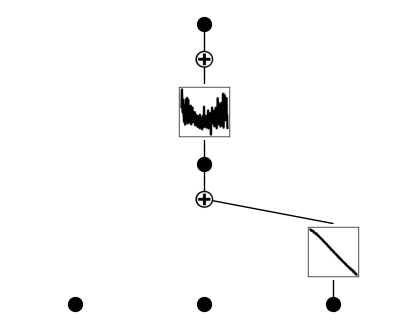

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 3.03e-02 | test_loss: 3.59e-02 | reg: 9.77e+00 | : 100%|█| 200/200 [00:56<00:00,  3.57


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 2.44e-02 | test_loss: 3.10e-02 | reg: 8.88e+00 | : 100%|█| 200/200 [00:57<00:00,  3.51


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 2.56e-02 | test_loss: 3.38e-02 | reg: 8.46e+00 | : 100%|█| 200/200 [01:01<00:00,  3.28


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 2.40e-02 | test_loss: 3.77e-02 | reg: 7.72e+00 | : 100%|█| 200/200 [01:06<00:00,  3.03


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 1.71e-02 | test_loss: 4.04e-02 | reg: 7.39e+00 | : 100%|█| 200/200 [00:47<00:00,  4.19


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 1.53e-02 | test_loss: 4.73e-02 | reg: 7.14e+00 | : 100%|█| 200/200 [01:33<00:00,  2.13


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 9.72e-03 | test_loss: 1.06e-01 | reg: 7.03e+00 | : 100%|█| 200/200 [02:20<00:00,  1.42


saving model version 0.13
Pruning model...
saving model version 0.14


| train_loss: 2.98e-02 | test_loss: 1.74e-01 | reg: 7.95e+00 | : 100%|█| 100/100 [00:38<00:00,  2.60


saving model version 0.15


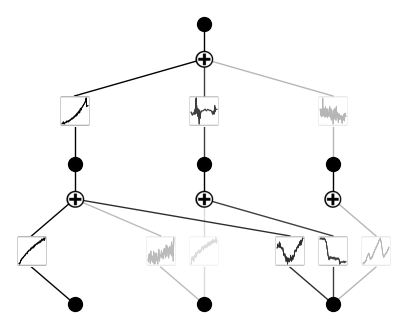

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 1.13e-01 | test_loss: 1.09e-01 | reg: 5.36e+00 | : 100%|█| 200/200 [01:18<00:00,  2.54


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 1.90e-01 | test_loss: 1.88e-01 | reg: 5.85e+00 | : 100%|█| 200/200 [00:39<00:00,  5.12


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 2.00e-01 | test_loss: 2.07e-01 | reg: 8.31e+00 | : 100%|█| 200/200 [00:50<00:00,  3.95


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 1.89e-01 | test_loss: 2.85e-01 | reg: 9.76e+00 | : 100%|█| 200/200 [01:09<00:00,  2.89


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 2.32e-01 | test_loss: 1.07e+00 | reg: 8.11e+00 | : 100%|█| 200/200 [02:09<00:00,  1.54


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 4.12e-01 | test_loss: 4.74e-01 | reg: 5.23e+00 | : 100%|█| 200/200 [01:38<00:00,  2.04


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 4.99e-01 | test_loss: 5.19e-01 | reg: 3.34e+00 | : 100%|█| 200/200 [03:23<00:00,  1.02


saving model version 0.13
Pruning model...
saving model version 0.14


| train_loss: 3.89e-01 | test_loss: 4.10e-01 | reg: 1.03e+01 | : 100%|█| 100/100 [00:59<00:00,  1.67


saving model version 0.15


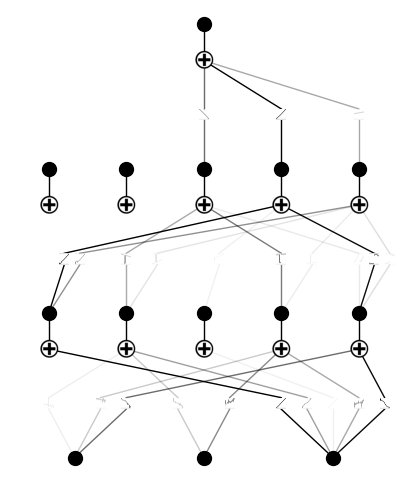

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 1.68e-02 | test_loss: 2.19e-02 | reg: 6.68e+00 | : 100%|█| 200/200 [01:27<00:00,  2.28


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 1.37e-02 | test_loss: 2.01e-02 | reg: 5.56e+00 | : 100%|█| 200/200 [01:31<00:00,  2.18


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 1.76e-02 | test_loss: 2.46e-02 | reg: 6.36e+00 | : 100%|█| 200/200 [01:37<00:00,  2.04


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 1.62e-02 | test_loss: 2.43e-02 | reg: 6.23e+00 | : 100%|█| 200/200 [01:39<00:00,  2.01


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 1.68e-02 | test_loss: 2.97e-02 | reg: 6.13e+00 | : 100%|█| 200/200 [01:13<00:00,  2.73


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 3.07e-02 | test_loss: 7.21e-02 | reg: 6.42e+00 | : 100%|█| 200/200 [01:46<00:00,  1.87


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 2.64e-02 | test_loss: 6.62e-02 | reg: 6.27e+00 | : 100%|█| 200/200 [01:59<00:00,  1.67


saving model version 0.13
Pruning model...
saving model version 0.14


| train_loss: 3.43e-02 | test_loss: 1.45e-01 | reg: 8.35e+00 | : 100%|█| 100/100 [00:43<00:00,  2.29


saving model version 0.15


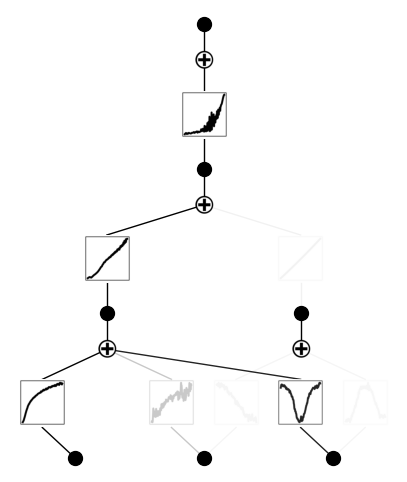

⚠️ WARNING: No model achieved RMSE < 1e-2 for dataset III.17.37
Pruned KAN Smallest Shape: None, 
Pruned KAN lowest loss Shape: [3, 2, 1, 1], 
Pruned KAN lowest loss: 2.0126e-02
--------------------------------
Final Results for dataset III.17.37:
Pruned KAN Smallest Shape: None, 
Pruned KAN lowest loss Shape: [3, 2, 1, 1], 
Pruned KAN lowest loss: 2.0126e-02


In [11]:
results_III_17_37 = full_feynman_experiment(dataset='III.17.37', shape_human=[3,3,3,2,2,1], seeds=[171], skip=['human', 'mlp', 'unpruned'], depths=[2,3], plot_model=True, plot_before_prune=True)

--------------------------------
Running Pruned KAN Experiment...
checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 2.47e-01 | test_loss: 2.57e-01 | reg: 2.47e-01 | : 100%|█| 200/200 [00:18<00:00, 10.96


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 2.47e-01 | test_loss: 2.57e-01 | reg: 1.04e-01 | : 100%|█| 200/200 [00:43<00:00,  4.60


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 2.47e-01 | test_loss: 2.57e-01 | reg: 4.88e-02 | : 100%|█| 200/200 [00:36<00:00,  5.45


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 2.47e-01 | test_loss: 2.57e-01 | reg: 3.33e-02 | : 100%|█| 200/200 [00:29<00:00,  6.69


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 2.47e-01 | test_loss: 2.57e-01 | reg: 2.94e-02 | : 100%|█| 200/200 [00:31<00:00,  6.44


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 2.47e-01 | test_loss: 2.58e-01 | reg: 3.23e-02 | : 100%|█| 200/200 [01:13<00:00,  2.72


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 2.47e-01 | test_loss: 2.58e-01 | reg: 5.68e-02 | : 100%|█| 200/200 [01:29<00:00,  2.24


saving model version 0.13
Pruning model...
saving model version 0.14


| train_loss: 2.46e-01 | test_loss: 2.58e-01 | reg: 9.47e-01 | : 100%|█| 100/100 [00:20<00:00,  4.91


saving model version 0.15


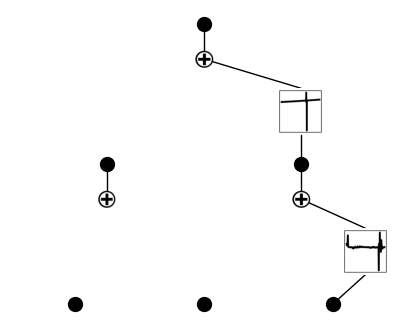

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 6.98e-02 | test_loss: 7.62e-02 | reg: 8.77e+00 | : 100%|█| 200/200 [01:01<00:00,  3.27


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 5.99e-02 | test_loss: 6.84e-02 | reg: 8.56e+00 | : 100%|█| 200/200 [01:03<00:00,  3.14


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 5.40e-02 | test_loss: 7.34e-02 | reg: 8.37e+00 | : 100%|█| 200/200 [01:00<00:00,  3.29


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 4.71e-02 | test_loss: 7.03e-02 | reg: 8.04e+00 | : 100%|█| 200/200 [01:05<00:00,  3.06


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 2.43e-02 | test_loss: 9.86e-02 | reg: 7.80e+00 | : 100%|█| 200/200 [01:22<00:00,  2.43


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 1.39e-02 | test_loss: 1.21e-01 | reg: 7.55e+00 | : 100%|█| 200/200 [01:45<00:00,  1.90


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 9.32e-03 | test_loss: 1.22e-01 | reg: 7.47e+00 | : 100%|█| 200/200 [02:04<00:00,  1.61


saving model version 0.13
Pruning model...
saving model version 0.14


| train_loss: 1.17e-02 | test_loss: 1.58e-01 | reg: 8.07e+00 | : 100%|█| 100/100 [00:47<00:00,  2.12


saving model version 0.15


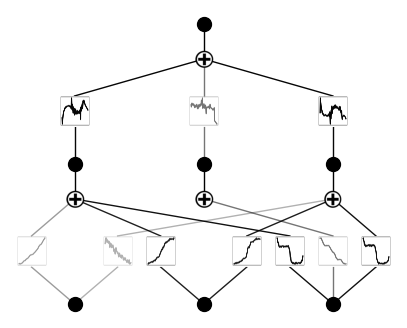

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 2.47e-01 | test_loss: 2.57e-01 | reg: 2.51e-01 | : 100%|█| 200/200 [00:26<00:00,  7.47


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 2.47e-01 | test_loss: 2.57e-01 | reg: 1.27e-01 | : 100%|█| 200/200 [00:40<00:00,  4.90


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 2.47e-01 | test_loss: 2.58e-01 | reg: 4.92e-02 | : 100%|█| 200/200 [01:03<00:00,  3.14


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 2.47e-01 | test_loss: 2.58e-01 | reg: 2.54e-02 | : 100%|█| 200/200 [01:08<00:00,  2.91


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 2.47e-01 | test_loss: 2.57e-01 | reg: 1.20e-02 | : 100%|█| 200/200 [00:57<00:00,  3.48


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 2.47e-01 | test_loss: 2.58e-01 | reg: 1.14e-02 | : 100%|█| 200/200 [01:17<00:00,  2.60


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 2.47e-01 | test_loss: 2.58e-01 | reg: 2.60e-02 | : 100%|█| 200/200 [01:20<00:00,  2.48


saving model version 0.13
Pruning model...
saving model version 0.14


| train_loss: 2.37e-01 | test_loss: 2.62e-01 | reg: 1.78e+00 | : 100%|█| 100/100 [00:50<00:00,  1.98


saving model version 0.15


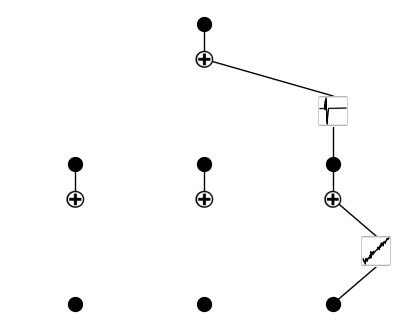

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 6.93e-02 | test_loss: 7.59e-02 | reg: 8.82e+00 | : 100%|█| 200/200 [01:00<00:00,  3.29


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 6.07e-02 | test_loss: 6.92e-02 | reg: 8.73e+00 | : 100%|█| 200/200 [01:07<00:00,  2.97


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 4.82e-02 | test_loss: 6.02e-02 | reg: 8.40e+00 | : 100%|█| 200/200 [01:03<00:00,  3.14


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 4.10e-02 | test_loss: 6.82e-02 | reg: 8.11e+00 | : 100%|█| 200/200 [01:05<00:00,  3.04


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 2.18e-02 | test_loss: 8.86e-02 | reg: 7.96e+00 | : 100%|█| 200/200 [01:23<00:00,  2.39


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 2.64e-02 | test_loss: 1.89e-01 | reg: 6.96e+00 | : 100%|█| 200/200 [01:48<00:00,  1.84


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 9.97e-03 | test_loss: 1.90e-01 | reg: 6.73e+00 | : 100%|█| 200/200 [02:43<00:00,  1.22


saving model version 0.13
Pruning model...
saving model version 0.14


| train_loss: 1.08e-02 | test_loss: 2.11e-01 | reg: 6.95e+00 | : 100%|█| 100/100 [00:47<00:00,  2.13


saving model version 0.15


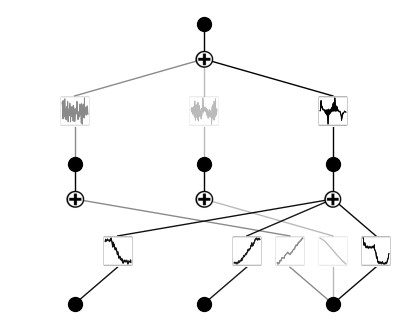

⚠️ WARNING: No model achieved RMSE < 1e-2 for dataset I.18.4
Pruned KAN Smallest Shape: None, 
Pruned KAN lowest loss Shape: [3, 3, 1], 
Pruned KAN lowest loss: 6.0185e-02
--------------------------------
Final Results for dataset I.18.4:
Pruned KAN Smallest Shape: None, 
Pruned KAN lowest loss Shape: [3, 3, 1], 
Pruned KAN lowest loss: 6.0185e-02


In [12]:
results_I_16_6 = full_feynman_experiment(dataset='I.18.4', shape_human=[6, 4, 2, 1, 1], seeds=[171], skip=['unpruned','human','mlp'], depths=[2,2], plot_model=True, plot_before_prune=True)

In [39]:
results_I_16_6 = full_feynman_experiment(dataset='I.26.2', shape_human=[2,2,2,1,1], seeds=[171], skip=['pruned'])

Running Human-constructed KAN Experiment...
checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 4.60e-03 | test_loss: 4.51e-03 | reg: 1.71e+01 | : 100%|█| 200/200 [01:02<00:00,  3.22


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 3.86e-03 | test_loss: 3.86e-03 | reg: 1.64e+01 | : 100%|█| 200/200 [01:03<00:00,  3.17


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 6.68e-03 | test_loss: 7.05e-03 | reg: 1.51e+01 | : 100%|█| 200/200 [01:08<00:00,  2.93


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 2.93e-03 | test_loss: 3.12e-03 | reg: 1.50e+01 | : 100%|█| 200/200 [01:00<00:00,  3.28


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 1.69e-03 | test_loss: 3.30e-03 | reg: 1.50e+01 | : 100%|█| 200/200 [00:56<00:00,  3.54


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 1.23e-03 | test_loss: 2.65e-02 | reg: 1.50e+01 | : 100%|█| 200/200 [00:49<00:00,  4.07


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 4.86e-04 | test_loss: 4.62e-02 | reg: 1.50e+01 | : 100%|█| 200/200 [00:52<00:00,  3.83


saving model version 0.13
Best Test RMSE for human-constructed KAN on dataset I.26.2: 3.1184e-03
Best Test RMSE for human-constructed KAN on dataset I.26.2: 3.1184e-03
--------------------------------
Running Not Pruned KAN Experiment...
checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 5.60e-03 | test_loss: 5.45e-03 | reg: 1.49e+01 | : 100%|█| 200/200 [00:41<00:00,  4.87


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 2.66e-03 | test_loss: 3.11e-03 | reg: 1.50e+01 | : 100%|█| 200/200 [00:42<00:00,  4.66


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 8.73e-04 | test_loss: 1.72e-03 | reg: 1.50e+01 | : 100%|█| 200/200 [00:31<00:00,  6.36


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 2.17e-04 | test_loss: 9.87e-04 | reg: 1.50e+01 | : 100%|█| 200/200 [00:43<00:00,  4.57


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 1.01e-04 | test_loss: 1.04e-03 | reg: 1.50e+01 | : 100%|█| 200/200 [00:21<00:00,  9.33


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 3.42e-05 | test_loss: 1.11e-03 | reg: 1.50e+01 | : 100%|█| 200/200 [00:30<00:00,  6.48


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 9.88e-06 | test_loss: 4.48e-03 | reg: 1.50e+01 | : 100%|█| 200/200 [00:42<00:00,  4.70


saving model version 0.13
checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 2.23e-03 | test_loss: 2.31e-03 | reg: 2.47e+01 | : 100%|█| 200/200 [01:06<00:00,  2.99


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 1.13e-03 | test_loss: 1.60e-03 | reg: 2.44e+01 | : 100%|█| 200/200 [01:07<00:00,  2.97


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 2.71e-04 | test_loss: 7.96e-04 | reg: 2.44e+01 | : 100%|█| 200/200 [00:59<00:00,  3.36


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 1.24e-04 | test_loss: 6.75e-04 | reg: 2.44e+01 | : 100%|█| 200/200 [00:39<00:00,  5.12


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 3.08e-05 | test_loss: 8.06e-04 | reg: 2.44e+01 | : 100%|█| 200/200 [00:37<00:00,  5.32


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 2.23e-05 | test_loss: 1.42e-03 | reg: 2.43e+01 | : 100%|█| 200/200 [00:50<00:00,  3.95


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 7.16e-06 | test_loss: 2.15e-03 | reg: 2.43e+01 | : 100%|█| 200/200 [01:12<00:00,  2.75


saving model version 0.13
checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 1.84e-03 | test_loss: 2.35e-03 | reg: 3.20e+01 | : 100%|█| 200/200 [01:28<00:00,  2.25


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 9.02e-04 | test_loss: 9.74e-04 | reg: 3.14e+01 | : 100%|█| 200/200 [01:27<00:00,  2.28


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 2.92e-04 | test_loss: 6.96e-04 | reg: 3.14e+01 | : 100%|█| 200/200 [01:18<00:00,  2.56


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 9.93e-05 | test_loss: 4.06e-03 | reg: 3.12e+01 | : 100%|█| 200/200 [01:06<00:00,  2.99


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 2.95e-05 | test_loss: 1.65e-02 | reg: 3.12e+01 | : 100%|█| 200/200 [00:53<00:00,  3.74


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 1.26e-05 | test_loss: 1.89e-02 | reg: 3.12e+01 | : 100%|█| 200/200 [01:13<00:00,  2.71


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 5.22e-06 | test_loss: 2.23e-02 | reg: 3.12e+01 | : 100%|█| 200/200 [01:38<00:00,  2.04


saving model version 0.13
checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 3.08e-03 | test_loss: 3.40e-03 | reg: 3.75e+01 | : 100%|█| 200/200 [02:04<00:00,  1.60


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 2.07e-03 | test_loss: 2.32e-03 | reg: 3.74e+01 | : 100%|█| 200/200 [01:21<00:00,  2.45


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 6.10e-04 | test_loss: 7.61e-04 | reg: 3.74e+01 | : 100%|█| 200/200 [02:14<00:00,  1.49


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 1.62e-04 | test_loss: 5.62e-04 | reg: 3.74e+01 | : 100%|█| 200/200 [01:50<00:00,  1.81


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 5.57e-05 | test_loss: 4.01e-03 | reg: 3.74e+01 | : 100%|█| 200/200 [01:35<00:00,  2.08


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 3.89e-05 | test_loss: 2.55e-02 | reg: 3.74e+01 | : 100%|█| 200/200 [01:35<00:00,  2.09


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 1.93e-01 | test_loss: 2.20e-01 | reg: 3.36e+01 | : 100%|█| 200/200 [06:11<00:00,  1.86


saving model version 0.13
checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 5.51e-03 | test_loss: 9.41e-03 | reg: 4.10e+01 | : 100%|█| 200/200 [02:29<00:00,  1.34


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 1.71e-03 | test_loss: 7.30e-03 | reg: 4.12e+01 | : 100%|█| 200/200 [02:11<00:00,  1.52


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 3.92e-04 | test_loss: 6.70e-03 | reg: 4.12e+01 | : 100%|█| 200/200 [02:32<00:00,  1.31


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 1.14e-04 | test_loss: 7.04e-03 | reg: 4.12e+01 | : 100%|█| 200/200 [01:49<00:00,  1.83


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 3.48e-05 | test_loss: 3.34e-02 | reg: 4.12e+01 | : 100%|█| 200/200 [01:59<00:00,  1.67


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 7.70e-05 | test_loss: 4.45e-02 | reg: 4.09e+01 | : 100%|█| 200/200 [03:12<00:00,  1.04


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 3.41e-01 | test_loss: 3.34e-01 | reg: 3.55e+01 | : 100%|█| 200/200 [04:39<00:00,  1.40


saving model version 0.13
Best Test RMSE for not pruned KAN on dataset I.26.2: 5.6212e-04
--------------------------------
Running MLP Experiment...


| train_loss: 4.82e-02 | test_loss: 4.68e-02 | reg: 3.43e+01 | : 100%|█| 1400/1400 [00:13<00:00, 105
| train_loss: 2.96e-01 | test_loss: 2.92e-01 | reg: 1.73e+01 | : 100%|█| 1400/1400 [00:13<00:00, 107
| train_loss: 3.00e-02 | test_loss: 2.86e-02 | reg: 5.86e+01 | : 100%|█| 1400/1400 [00:15<00:00, 89.
| train_loss: 1.65e-02 | test_loss: 1.47e-02 | reg: 6.94e+01 | : 100%|█| 1400/1400 [00:18<00:00, 75.
| train_loss: 3.06e-01 | test_loss: 3.07e-01 | reg: 3.14e+01 | : 100%|█| 1400/1400 [00:14<00:00, 95.
| train_loss: 5.45e-03 | test_loss: 4.98e-03 | reg: 6.78e+01 | : 100%|█| 1400/1400 [00:30<00:00, 46.
| train_loss: 7.14e-03 | test_loss: 6.32e-03 | reg: 8.30e+01 | : 100%|█| 1400/1400 [00:31<00:00, 44.
| train_loss: 1.32e-01 | test_loss: 1.43e-01 | reg: 4.85e+01 | : 100%|█| 1400/1400 [00:14<00:00, 95.
| train_loss: 8.38e-03 | test_loss: 7.37e-03 | reg: 8.72e+01 | : 100%|█| 1400/1400 [00:36<00:00, 37.
| train_loss: 1.41e-02 | test_loss: 1.35e-02 | reg: 1.06e+02 | : 100%|█| 1400/1400 [00:30<0

MLP lowest loss: 2.3017e-03
--------------------------------
Final Results for dataset I.26.2:
Human-constructed KAN loss: 3.1184e-03
UnPruned KAN lowest loss: 5.6212e-04
MLP lowest loss: 2.3017e-03


--------------------------------
Running Pruned KAN Experiment...
checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 4.78e-02 | test_loss: 4.33e-02 | reg: 8.66e+00 | : 100%|█| 200/200 [00:33<00:00,  6.03


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 4.88e-02 | test_loss: 4.40e-02 | reg: 8.63e+00 | : 100%|█| 200/200 [00:19<00:00, 10.23


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 4.84e-02 | test_loss: 4.35e-02 | reg: 8.63e+00 | : 100%|█| 200/200 [00:15<00:00, 13.15


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 4.84e-02 | test_loss: 4.40e-02 | reg: 8.63e+00 | : 100%|█| 200/200 [00:12<00:00, 16.15


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 4.84e-02 | test_loss: 4.45e-02 | reg: 8.64e+00 | : 100%|█| 200/200 [00:12<00:00, 15.48


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 4.86e-02 | test_loss: 4.47e-02 | reg: 8.74e+00 | : 100%|█| 200/200 [00:16<00:00, 12.19


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 4.82e-02 | test_loss: 4.28e-02 | reg: 9.48e+00 | : 100%|█| 200/200 [00:31<00:00,  6.37


saving model version 0.13
Pruning model...
saving model version 0.14


| train_loss: 2.52e-04 | test_loss: 2.79e-02 | reg: 9.54e+00 | : 100%|█| 100/100 [00:46<00:00,  2.16


saving model version 0.15


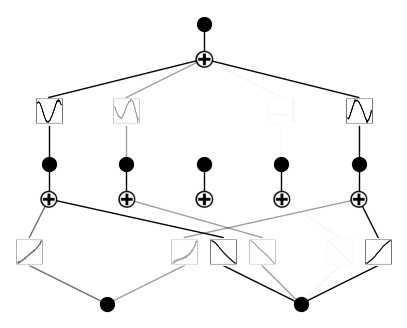

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 1.70e-02 | test_loss: 1.64e-02 | reg: 7.56e+00 | : 100%|█| 200/200 [00:39<00:00,  5.06


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 2.07e-02 | test_loss: 2.04e-02 | reg: 7.55e+00 | : 100%|█| 200/200 [00:26<00:00,  7.63


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 1.10e-02 | test_loss: 1.02e-02 | reg: 7.37e+00 | : 100%|█| 200/200 [00:49<00:00,  4.01


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 9.11e-03 | test_loss: 8.58e-03 | reg: 7.36e+00 | : 100%|█| 200/200 [00:28<00:00,  7.03


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 9.11e-03 | test_loss: 8.57e-03 | reg: 7.36e+00 | : 100%|█| 200/200 [00:19<00:00, 10.45


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 9.12e-03 | test_loss: 8.63e-03 | reg: 7.36e+00 | : 100%|█| 200/200 [00:22<00:00,  8.81


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 9.12e-03 | test_loss: 1.12e-02 | reg: 7.36e+00 | : 100%|█| 200/200 [00:34<00:00,  5.87


saving model version 0.13
Pruning model...
saving model version 0.14


| train_loss: 3.49e-04 | test_loss: 1.75e-02 | reg: 9.03e+00 | : 100%|█| 100/100 [00:27<00:00,  3.60


saving model version 0.15


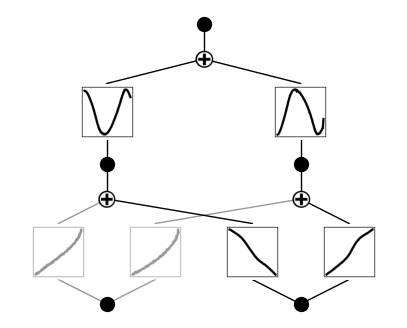

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 2.44e-01 | test_loss: 2.42e-01 | reg: 4.19e+00 | : 100%|█| 200/200 [01:04<00:00,  3.12


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 2.44e-01 | test_loss: 2.43e-01 | reg: 4.13e+00 | : 100%|█| 200/200 [01:29<00:00,  2.24


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 2.45e-01 | test_loss: 2.43e-01 | reg: 4.15e+00 | : 100%|█| 200/200 [00:59<00:00,  3.34


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 2.44e-01 | test_loss: 2.43e-01 | reg: 4.12e+00 | : 100%|█| 200/200 [01:08<00:00,  2.94


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 2.44e-01 | test_loss: 2.43e-01 | reg: 4.18e+00 | : 100%|█| 200/200 [00:44<00:00,  4.54


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 2.44e-01 | test_loss: 2.43e-01 | reg: 4.18e+00 | : 100%|█| 200/200 [00:57<00:00,  3.49


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: nan | test_loss: nan | reg: nan | :   2%|▎            | 5/200 [00:09<05:58,  1.84s/it]



Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.
lstsq failed
Error running run_kan_feynman with depth=3, lamb=0.01, seed=171: cannot access local variable 'coef' where it is not associated with a value
checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 2.01e-02 | test_loss: 1.90e-02 | reg: 9.85e+00 | : 100%|█| 200/200 [01:29<00:00,  2.25


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 1.31e-02 | test_loss: 1.29e-02 | reg: 8.81e+00 | : 100%|█| 200/200 [01:33<00:00,  2.14


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 8.42e-03 | test_loss: 8.56e-03 | reg: 8.47e+00 | : 100%|█| 200/200 [01:35<00:00,  2.09


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 7.68e-03 | test_loss: 9.91e-03 | reg: 8.44e+00 | : 100%|█| 200/200 [01:34<00:00,  2.13


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 6.93e-03 | test_loss: 1.07e-02 | reg: 8.41e+00 | : 100%|█| 200/200 [01:04<00:00,  3.08


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 6.75e-03 | test_loss: 1.16e-02 | reg: 8.41e+00 | : 100%|█| 200/200 [01:24<00:00,  2.36


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 6.24e-03 | test_loss: 1.24e-02 | reg: 8.40e+00 | : 100%|█| 200/200 [02:31<00:00,  1.32


saving model version 0.13
Pruning model...
saving model version 0.14


| train_loss: 2.66e-01 | test_loss: 2.74e-01 | reg: 1.18e+01 | : 100%|█| 100/100 [00:37<00:00,  2.70


saving model version 0.15


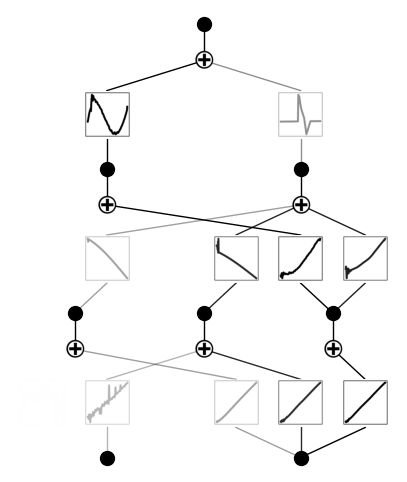

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 4.59e-01 | test_loss: 4.44e-01 | reg: 8.30e-01 | : 100%|█| 200/200 [01:05<00:00,  3.07


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 4.60e-01 | test_loss: 4.44e-01 | reg: 7.15e-01 | : 100%|█| 200/200 [01:06<00:00,  2.99


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 4.59e-01 | test_loss: 4.44e-01 | reg: 3.64e-01 | : 100%|█| 200/200 [01:03<00:00,  3.13


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 4.59e-01 | test_loss: 4.44e-01 | reg: 2.36e-01 | : 100%|█| 200/200 [01:18<00:00,  2.53


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 4.59e-01 | test_loss: 4.44e-01 | reg: 2.80e-01 | : 100%|█| 200/200 [00:40<00:00,  4.94


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 4.59e-01 | test_loss: 4.44e-01 | reg: 3.02e-01 | : 100%|█| 200/200 [02:23<00:00,  1.39


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 4.59e-01 | test_loss: 4.44e-01 | reg: 3.70e+00 | : 100%|█| 200/200 [03:01<00:00,  1.10


saving model version 0.13
Pruning model...
saving model version 0.14


| train_loss: 4.47e-01 | test_loss: 4.33e-01 | reg: 6.18e+00 | : 100%|█| 100/100 [01:10<00:00,  1.42


saving model version 0.15


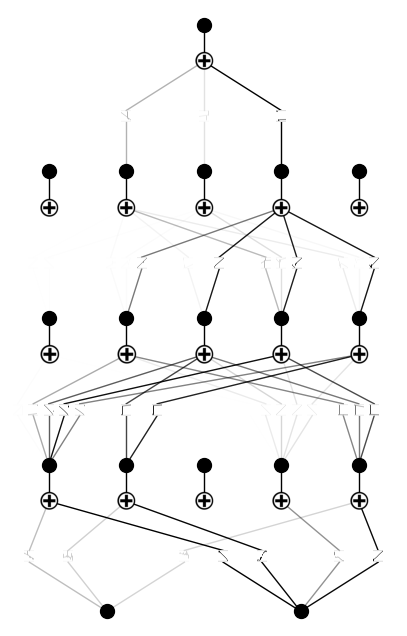

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 1.71e-02 | test_loss: 1.66e-02 | reg: 1.04e+01 | : 100%|█| 200/200 [02:11<00:00,  1.52


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 1.97e-02 | test_loss: 3.32e-02 | reg: 1.12e+01 | : 100%|█| 200/200 [02:10<00:00,  1.53


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 1.75e-02 | test_loss: 3.88e-02 | reg: 1.18e+01 | : 100%|█| 200/200 [02:23<00:00,  1.39


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 1.24e-02 | test_loss: 1.26e-01 | reg: 8.91e+00 | : 100%|█| 200/200 [02:34<00:00,  1.30


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 1.90e-01 | test_loss: 2.79e-01 | reg: 1.44e+01 | : 100%|█| 200/200 [02:42<00:00,  1.23


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 1.85e-01 | test_loss: 2.83e-01 | reg: 1.41e+01 | : 100%|█| 200/200 [03:52<00:00,  1.16


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 3.60e-01 | test_loss: 3.80e-01 | reg: 1.20e+01 | : 100%|█| 200/200 [06:17<00:00,  1.89


saving model version 0.13
Pruning model...
saving model version 0.14


| train_loss: 2.80e-01 | test_loss: 2.95e-01 | reg: 1.13e+01 | : 100%|█| 100/100 [01:56<00:00,  1.16


saving model version 0.15


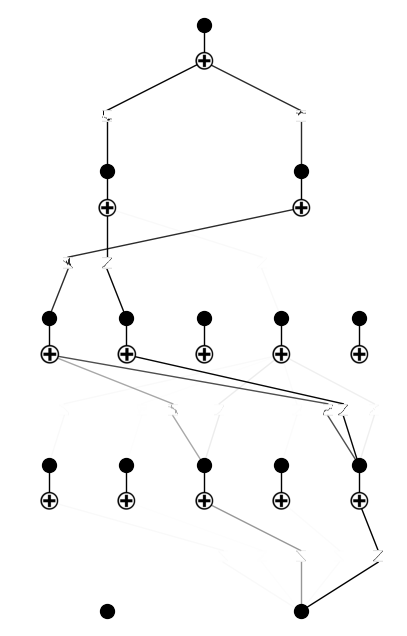

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 4.59e-01 | test_loss: 4.44e-01 | reg: 7.33e-01 | : 100%|█| 200/200 [00:46<00:00,  4.30


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 4.59e-01 | test_loss: 4.44e-01 | reg: 6.97e-01 | : 100%|█| 200/200 [01:03<00:00,  3.13


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 4.59e-01 | test_loss: 4.44e-01 | reg: 5.93e-01 | : 100%|█| 200/200 [01:26<00:00,  2.30


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 4.59e-01 | test_loss: 4.44e-01 | reg: 1.07e+00 | : 100%|█| 200/200 [02:47<00:00,  1.19


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 4.59e-01 | test_loss: 4.44e-01 | reg: 3.42e+00 | : 100%|█| 200/200 [01:19<00:00,  2.53


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 4.59e-01 | test_loss: 4.44e-01 | reg: 8.25e-01 | : 100%|█| 200/200 [02:13<00:00,  1.50


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 4.59e-01 | test_loss: 4.44e-01 | reg: 1.11e+00 | : 100%|█| 200/200 [03:38<00:00,  1.09


saving model version 0.13
Pruning model...
saving model version 0.14


| train_loss: 4.57e-01 | test_loss: 4.42e-01 | reg: 4.15e+00 | : 100%|█| 100/100 [00:56<00:00,  1.78


saving model version 0.15


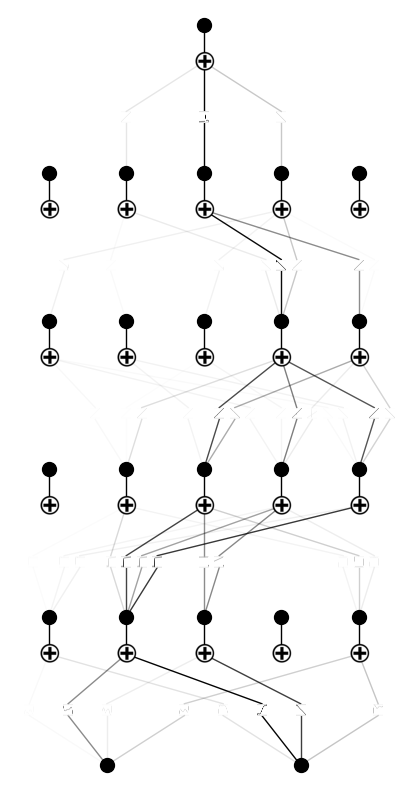

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 2.06e-02 | test_loss: 2.21e-02 | reg: 1.59e+01 | : 100%|█| 200/200 [02:48<00:00,  1.19


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 3.43e-02 | test_loss: 2.81e-02 | reg: 1.11e+01 | : 100%|█| 200/200 [02:50<00:00,  1.17


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 3.71e-02 | test_loss: 3.24e-01 | reg: 1.62e+01 | : 100%|█| 200/200 [03:08<00:00,  1.06


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 6.49e-02 | test_loss: 2.41e-01 | reg: 1.63e+01 | : 100%|█| 200/200 [03:11<00:00,  1.05


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 1.35e-01 | test_loss: 3.52e-01 | reg: 1.32e+01 | : 100%|█| 200/200 [03:32<00:00,  1.06


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 4.50e-01 | test_loss: 4.38e-01 | reg: 9.02e+00 | :  15%|▏| 30/200 [01:10<05:14,  1.85s

In [ ]:
results_I_16_6 = full_feynman_experiment(dataset='I.26.2', shape_human=[2,2,2,1,1], seeds=[171], skip=['unpruned','human','mlp'], plot_model=True, plot_before_prune=True)